In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import decoupler as dc
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from itertools import combinations
import anndata
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
#import scvi

import plotting_functions_f1 as pf

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
sex_palette = ['hotpink','dodgerblue']
geno_palette = ['#F4C245','#55AF5B','#C0BFBF','#4F6EAF','#52A5DB','#D83026','#683C91','#DA9CC1', 'tan']


In [3]:
adata1 = sc.read("../igvf_017/Heart/Heart_qc.h5ad")

adata2 = sc.read("../igvf_017/Heart/Heart_p4.h5ad")



In [4]:
adata1

AnnData object with n_obs × n_vars = 55646 × 56953
    obs: 'bc', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'subpool', 'bc1_well', 'bc2_well', 'bc3_well', 'Mouse_Tissue_ID', 'plate', 'well_type', 'Tissue', 'Genotype', 'Protocol', 'Chemistry', 'Multiplexed_sample1', 'Multiplexed_sample2', 'Row', 'Column', 'SampleType', 'Sex', 'Age', 'Notes', 'DOB', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Dissection_date', 'Dissection_time', 'Dissector', 'Tissue_weight_mg', 'mult_genotype_1', 'mult_genotype_2', 'mult_genotype', 'n_counts', 'B6WSBF1J', 'B6NZOF1J', 'B6J', 'B6NODF1J', 'B6AF1J', 'B6PWKF1J', 'B6129S1F1J', 'B6CASTF1J', 'doublet_scores'

In [5]:
adata2

AnnData object with n_obs × n_vars = 412281 × 56953
    obs: 'bc', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'subpool', 'bc1_well', 'bc2_well', 'bc3_well', 'Mouse_Tissue_ID', 'plate', 'well_type', 'Tissue', 'Genotype', 'Protocol', 'Chemistry', 'Multiplexed_sample1', 'Multiplexed_sample2', 'Row', 'Column', 'SampleType', 'Sex', 'Age', 'Notes', 'DOB', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Dissection_date', 'Dissection_time', 'Dissector', 'Tissue_weight_mg', 'Total_extracted_million', 'mult_genotype_1', 'mult_genotype_2', 'mult_genotype', 'n_counts', 'B6129S1F1J', 'B6CASTF1J', 'B6AF1J', 'B6PWKF1J', 'B6WSBF1J', 'B6NZOF1J', 'B6J', 'B6NODF1J', 'doublet_scores', 'batch'
    var: 'gene_name'

In [6]:
adata = adata1.concatenate(adata2, join='outer', index_unique=None)


In [7]:
# FIX 129 GENOTYPE....
adata.obs['Genotype'] = adata.obs['Genotype'].replace('B6129SF1J', 'B6129S1F1J')


In [8]:
adata.layers['raw_counts'] = adata.X.copy()
adata.var.rename(columns={'gene_name-1': 'gene_name'}, inplace=True)

# filtering cells by mt content 
adata.var['mt'] = adata.var['gene_name'].str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Plots before filtering

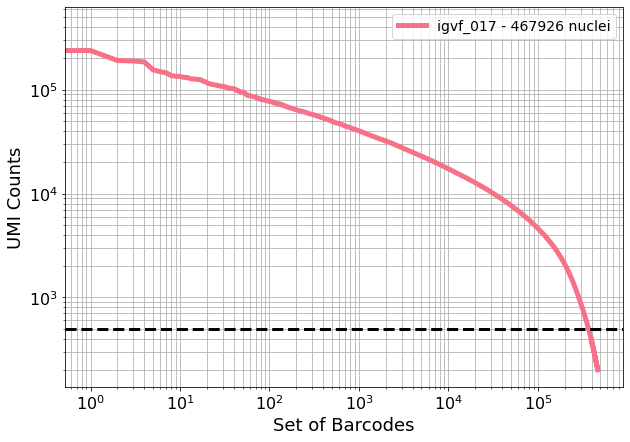

In [9]:
pf.plot_knee(adata, cutoff=500,figsize=(10, 7))
plt.show()

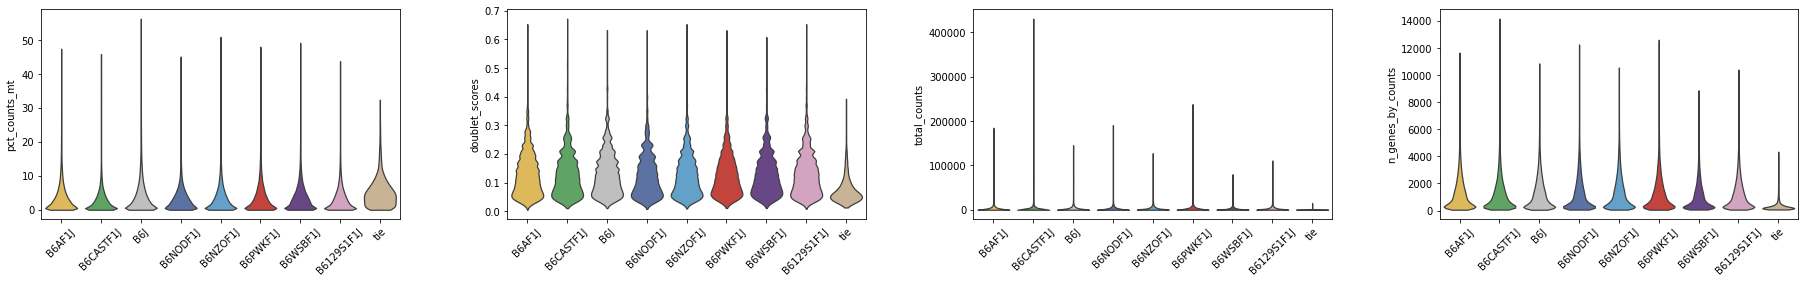

In [10]:
sc.pl.violin(adata, ['pct_counts_mt', 'doublet_scores', 'total_counts', 'n_genes_by_counts'],
             groupby = "Genotype", palette = geno_palette,
             jitter=0.4, multi_panel=True, size=0, rotation=45)

In [11]:
adata.obs['subpool'].value_counts()

subpool
67A    40966
67J    34196
67H    33358
67D    32844
67I    32466
67K    32219
67B    32062
67L    31988
67M    31517
67G    31439
67C    31420
67E    30756
67F    30309
67N    27707
67O    14680
Name: count, dtype: int64

# Preprocessing

In [12]:
### filtering data ###

sc.pp.filter_cells(adata, min_counts = 500) # UMI cutoff
sc.pp.filter_cells(adata, max_counts = 150000)
sc.pp.filter_cells(adata, min_genes = 250) # min number of genes per cell
adata = adata[adata.obs.pct_counts_mt < 5, :] # increased to 5% for less stringent filtering...

# filter cells by doublet score (scrublet)
adata = adata[adata.obs.doublet_scores < 0.25, :]

### normalize the data ###
sc.pp.normalize_total(adata, target_sum=1e4) # Counts per 10k
sc.pp.log1p(adata)

### calculate highly variable genes ###
# highly variable genes are used to compute the clustering 
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

adatas = adata[:, adata.var.highly_variable]


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [13]:
sc.pp.regress_out(adatas, ['pct_counts_mt','n_genes_by_counts'])


In [14]:
sc.pp.scale(adatas, max_value=10)
sc.tl.pca(adatas, svd_solver='arpack', use_highly_variable = True)
sc.pp.neighbors(adatas, n_neighbors=20, n_pcs=30)



/opt/apps/python/3.8.0/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/apps/python/3.8.0/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/apps/python/3.8.0/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDeprecationWarni

In [25]:
sc.tl.leiden(adatas, resolution = 1)

sc.tl.umap(adatas, min_dist = 0.5, spread =2.0)

adata.uns['neighbors'] = adatas.uns['neighbors']
adata.uns['leiden'] = adatas.uns['leiden']
adata.uns['umap'] = adatas.uns['umap']
adata.obs['leiden'] = adatas.obs['leiden']
adata.obsm = adatas.obsm
adata.obsp = adatas.obsp


In [26]:
adata.write_h5ad('../igvf_017/Heart/Heart_preprocessed.h5ad')


# Plots

In [27]:
adata = sc.read_h5ad("../igvf_017/Heart/Heart_preprocessed.h5ad")

In [28]:
adata

AnnData object with n_obs × n_vars = 261803 × 56953
    obs: 'bc', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'subpool', 'bc1_well', 'bc2_well', 'bc3_well', 'Mouse_Tissue_ID', 'plate', 'well_type', 'Tissue', 'Genotype', 'Protocol', 'Chemistry', 'Multiplexed_sample1', 'Multiplexed_sample2', 'Row', 'Column', 'SampleType', 'Sex', 'Age', 'Notes', 'DOB', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Dissection_date', 'Dissection_time', 'Dissector', 'Tissue_weight_mg', 'mult_genotype_1', 'mult_genotype_2', 'mult_genotype', 'n_counts', 'B6WSBF1J', 'B6NZOF1J', 'B6J', 'B6NODF1J', 'B6AF1J', 'B6PWKF1J', 'B6129S1F1J', 'B6CASTF1J', 'doublet_scores', 'Total_extracted_million', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Genotype_colors', 'Sex_colors', 'dendrogram_

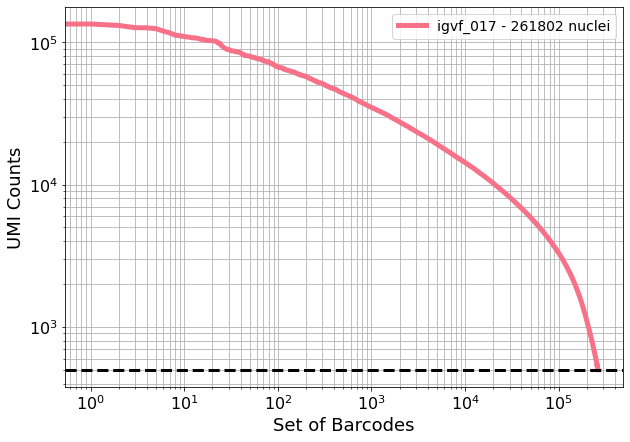

In [29]:
pf.plot_knee(adata, cutoff=500,figsize=(10, 7))
plt.show()

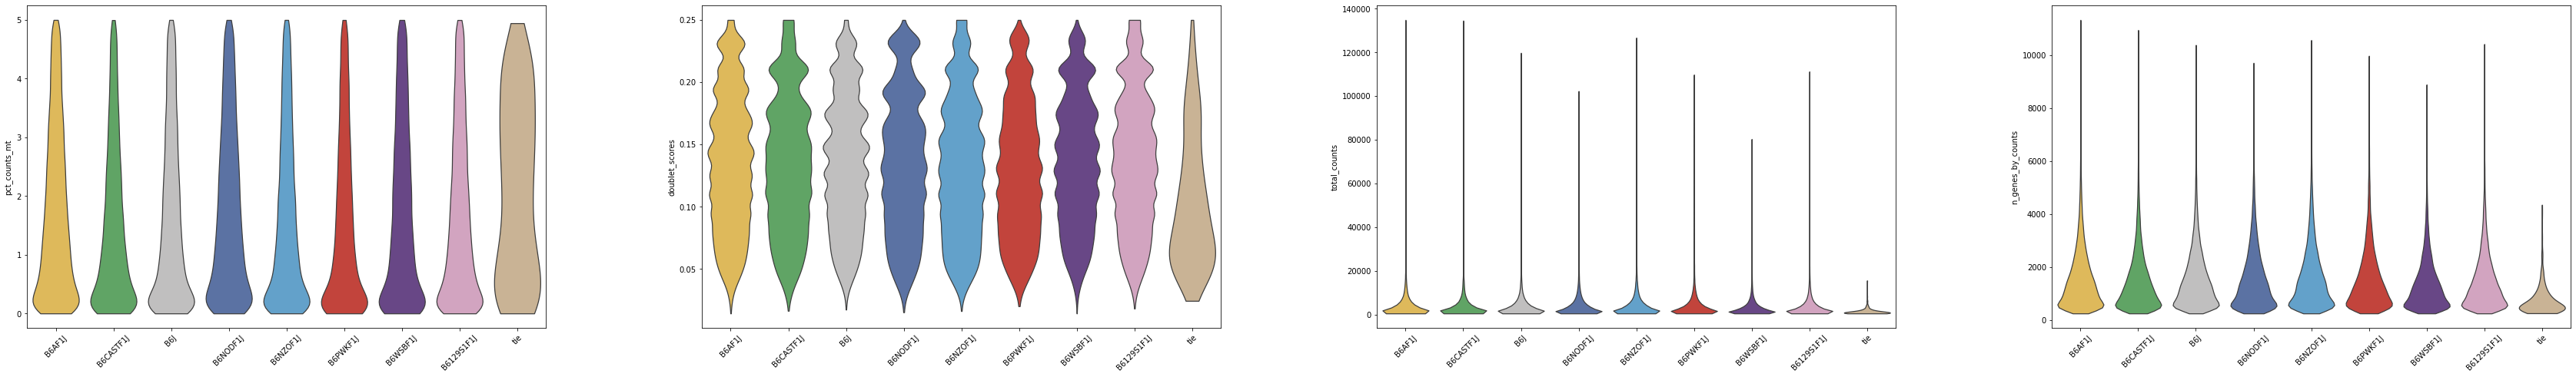

In [30]:
sc.pl.violin(adata, ['pct_counts_mt', 'doublet_scores', 'total_counts', 'n_genes_by_counts'],
             groupby = "Genotype", palette = geno_palette,
             jitter=0.4, multi_panel=True, size=0, rotation=45)

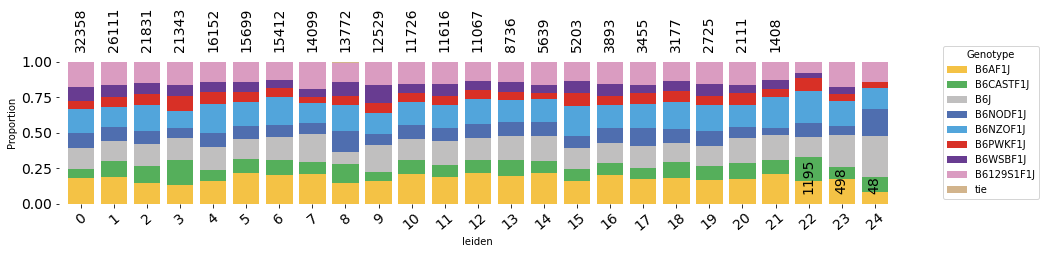

In [31]:
pf.stacked_barplot_proportions(adata.obs, 
                            'leiden', 'Genotype',
                            flip=False, fsize = (15,3), 
                            annotations = True)


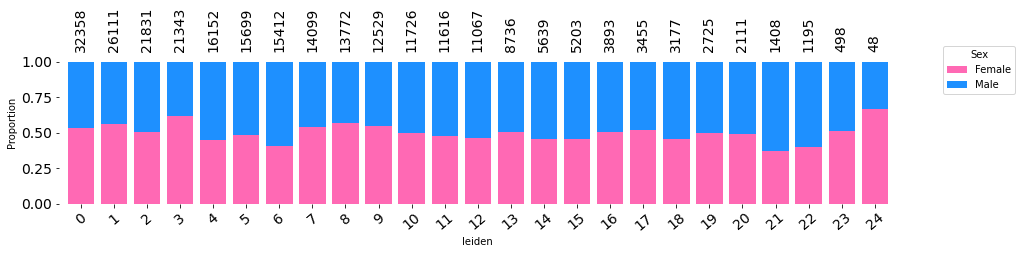

In [32]:
pf.stacked_barplot_proportions(adata.obs, 
                            'leiden', 'Sex',
                            flip=False, fsize = (15,3), 
                            annotations = True)


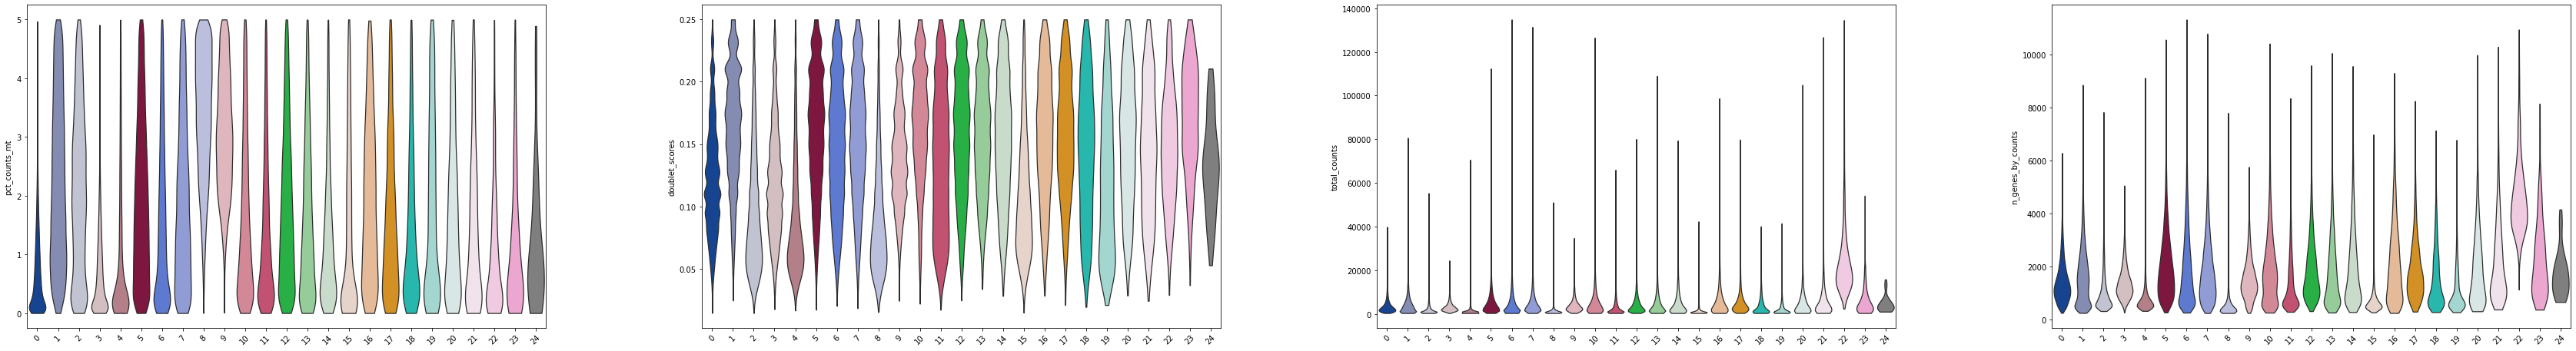

In [41]:
sc.pl.violin(adata, ['pct_counts_mt', 'doublet_scores', 'total_counts', 'n_genes_by_counts'],
             groupby = "leiden", 
             jitter=0.4, multi_panel=True, size=0, rotation=45)

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


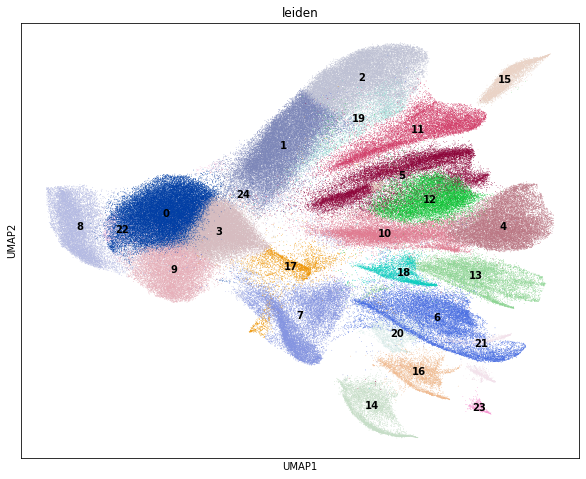

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


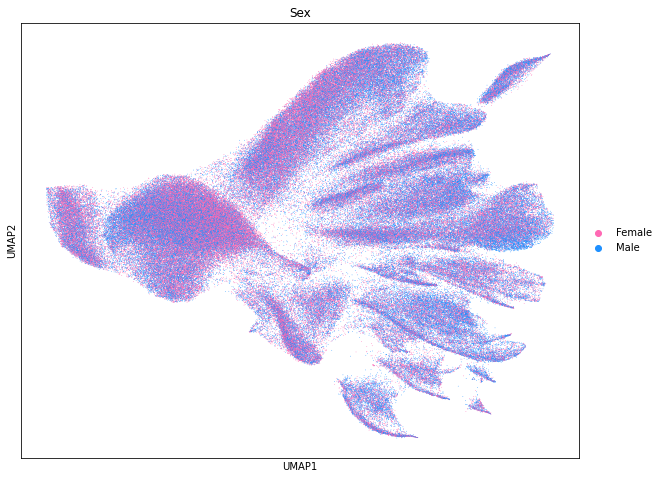

/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


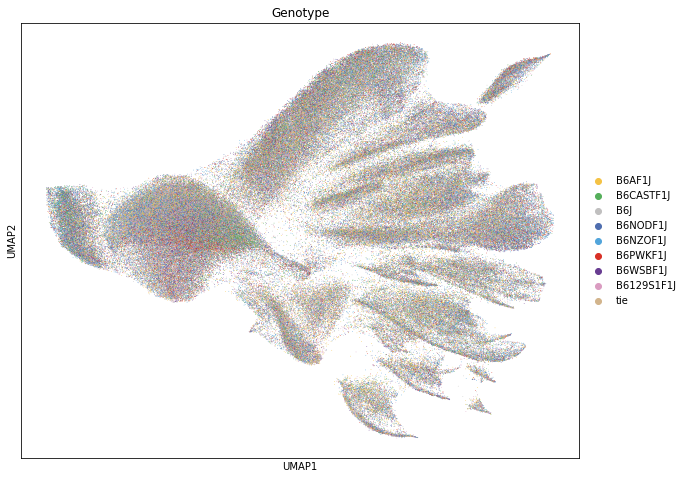

In [33]:
plt.rcParams['figure.figsize'] = (10, 8)

sc.pl.umap(adata, color=['leiden'], size=2, legend_loc = 'on data')

sc.pl.umap(adata, color=['Sex'], size = 2, palette = sex_palette)

sc.pl.umap(adata, color=['Genotype'], size = 2, palette = geno_palette)



# Annotation

categories: 0, 1, 2, etc.
var_group_labels: Fibroblast, Cardiomyocyte, Endothelial, etc.


/opt/apps/python/3.8.0/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


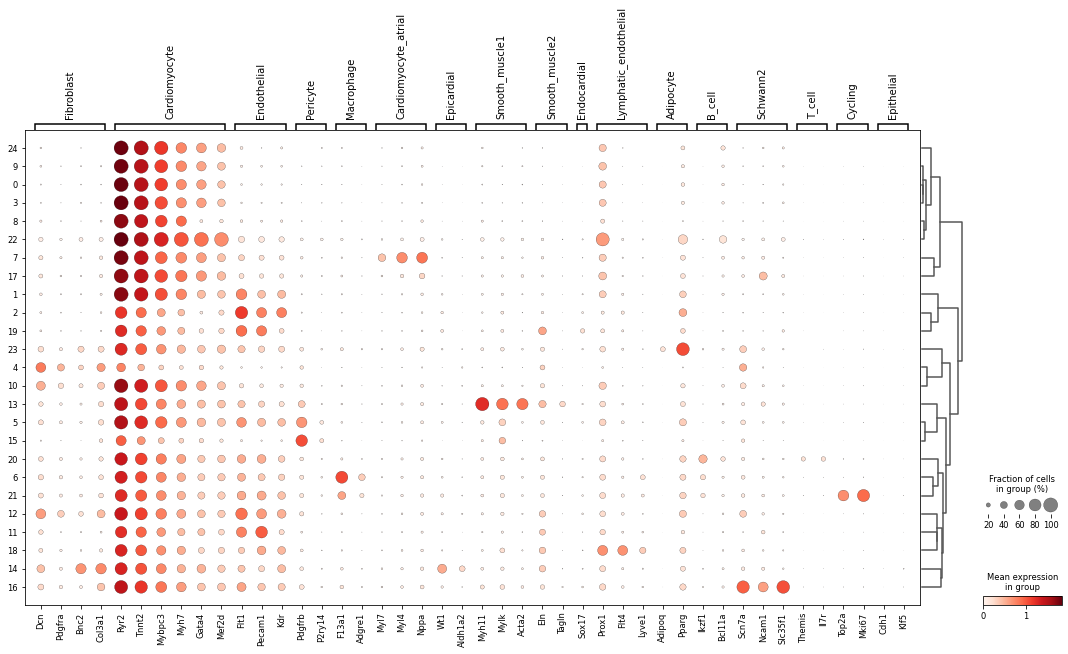

In [34]:
marker_genes_dict= {
    "Fibroblast": ["Dcn","Pdgfra","Bnc2","Col3a1"],
    "Cardiomyocyte": ["Ryr2","Tnnt2","Mybpc3","Myh7","Gata4","Mef2d"],
    "Endothelial": ["Flt1","Pecam1","Kdr"],
    "Pericyte": ["Pdgfrb","P2ry14"],
    "Macrophage": ["F13a1","Adgre1"],
    "Cardiomyocyte_atrial": ['Myl7','Myl4','Nppa'],
    "Epicardial": ["Wt1","Aldh1a2"],
    "Smooth_muscle1": ["Myh11","Mylk","Acta2"],
    "Smooth_muscle2": ["Eln","Tagln"],
    "Endocardial": ["Sox17"],
    "Lymphatic_endothelial": ["Prox1","Flt4","Lyve1"],
    "Adipocyte": ["Adipoq","Pparg"],
    "B_cell": ["Ikzf1","Bcl11a"],
    #"Schwann1": ["Mpz", "Pmp22", "Prx"], # myelinating
    "Schwann2": ["Scn7a","Ncam1","Slc35f1"], # non-myelinating
    "T_cell": ["Themis","Il7r"],
    "Cycling": ["Top2a","Mki67"],
    "Epithelial": ["Cdh1","Klf5"],


}

adata.var_names  = adata.var['gene_name']

sc.pl.dotplot(adata, marker_genes_dict, 'leiden',dendrogram=True, log=True)



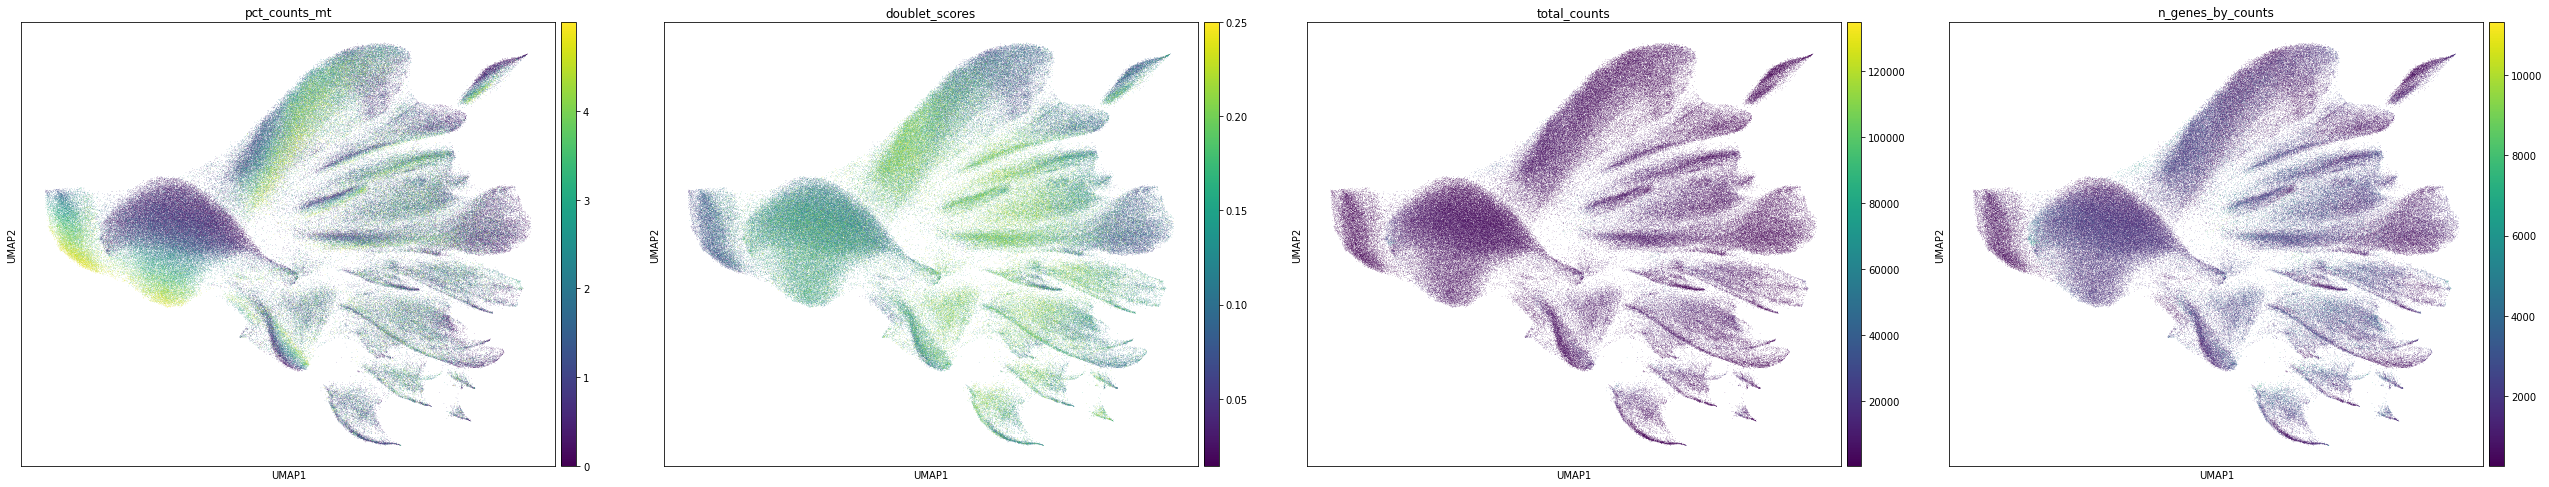

In [42]:
sc.pl.umap(adata, color=['pct_counts_mt', 'doublet_scores', 'total_counts', 'n_genes_by_counts'], size = 0.8, sort_order = True)



0 ventricular cardiac muscle cell
1 endothelial cell
2 endothelial cell
3 ventricular cardiac muscle cell
4 fibroblast
5 low quality?
6 macrophage
7 regular atrial cardiac myocyte
8 low quality?
9 ventricular cardiac muscle cell
10 fibroblast
11 low quality?
12 fibroblast
13 smooth muscle cell
14 mesothelial cell of epicardium
15 pericyte
16 Schwann cell
17 endothelial cell
18 endothelial cell of lymphatic vessel
19 ventricular cardiac muscle cell
20 lymphocyte
21 cycling
22 ventricular cardiac muscle cell
23 fat cell
24 ventricular cardiac muscle cell

